In [ ]:
import os

# enable scipy array API support for scikit-learn
os.environ["SCIPY_ARRAY_API"] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy loompy matplotlib mygene igraph scvi-tools scvi-colab celltypist cellxgene_census tiledbsoma

import scvi
import scanpy as sc
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import mygene as mg
import cellxgene_census
import pandas as pd
import loompy as lp
import tiledbsoma as soma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of fsspec[http] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.

### Predicting drug targets from scRNA-seq data

We will be working with the largest single-cell atlas in the world, containing 74 million human cells and 66,000 genes from [CELLXGENE](https://chanzuckerberg.github.io/cellxgene-census/).

The workflow for this project is as follows:

Data prep:

- Subset scRNA-seq data from larger dataset
- Do QC
- Normalize & scale data (log-transform)
- Isolate highly variable genes
- Label data with druggable targets (present or not in Open Targets list: positive and negative class)

Train RF model:

- Instantiate, train, validate and test supervised learning model to predict gene targets associated with drug efficacy
- Evaluate model performance
- Iterate on data to boost model performance


By the end of this notebook we will have designed a reproducible end to end bioinformatics pipeline incorporating single cell data pre-processing and analysis, model building, evaluation and optimization.

In [ ]:
with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        obs_coords=slice(0, 500),
        var_coords=slice(0,10000),
    )

    print(adata)

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 501 × 10001
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'


In [ ]:
#unique_diseases = adata.obs['disease'].unique()

#print(unique_diseases)

Let's extract COVID-19 data.

In [ ]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    human = census["census_data"]["homo_sapiens"]

    # query all COVID-19 cells
    query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(
            value_filter="disease == 'COVID-19'"
        ),
    )

    # convert obs iterator to pandas df
    obs_df = query.obs().concat().to_pandas()

    # take first 5000 cells of above query
    covid_cells = obs_df.iloc[:5000]
    cell_ids = covid_cells.index.tolist()

    # query experiment for all genes without filtering obs
    gene_query = human.axis_query(
        measurement_name="RNA"
    )
    all_var_df = gene_query.var().concat().to_pandas()
    var_ids = all_var_df.iloc[:20000].index.tolist()

    # final query: only selected 5000 COVID-19 cells and 20000 genes
    final_query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(coords=(cell_ids,)),
        var_query=soma.AxisQuery(coords=(var_ids,))
    )

    covid_adata = final_query.to_anndata(X_name="raw")

In [ ]:
covid_adata

AnnData object with n_obs × n_vars = 5000 × 20000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

Now let's grab breast cancer data.

In [ ]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    human = census["census_data"]["homo_sapiens"]

    # query all breast cancer cells
    query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(
            value_filter="disease == 'breast cancer'"
        ),
    )

    # convert obs iterator to pandas df
    obs_df = query.obs().concat().to_pandas()

    # take first 5000 cells of above query
    bc_cells = obs_df.iloc[:5000]
    cell_ids = bc_cells.index.tolist()

    # query experiment for all genes without filtering obs
    gene_query = human.axis_query(
        measurement_name="RNA"
    )
    all_var_df = gene_query.var().concat().to_pandas()
    var_ids = all_var_df.iloc[:20000].index.tolist()

    # final query: only selected 5000 breast cancer cells and 20000 genes
    final_query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(coords=(cell_ids,)),
        var_query=soma.AxisQuery(coords=(var_ids,))
    )

    bc_adata = final_query.to_anndata(X_name="raw")

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


In [ ]:
bc_adata

AnnData object with n_obs × n_vars = 1000 × 61888
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

Now let's grab Alzheimer's data.

In [ ]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    human = census["census_data"]["homo_sapiens"]

    # query all alzheimer's cells
    query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(
            value_filter="disease == 'Alzheimer disease'"
        ),
    )

    # convert obs iterator to pandas df
    obs_df = query.obs().concat().to_pandas()

    # take first 5000 cells
    az_cells = obs_df.iloc[:5000]
    cell_ids = az_cells.index.tolist()

    # query experiment for all genes without filtering obs
    gene_query = human.axis_query(
        measurement_name="RNA"
    )
    all_var_df = gene_query.var().concat().to_pandas()
    var_ids = all_var_df.iloc[:20000].index.tolist()

    # final query: only selected 5000 alzheimer's cells and 20000 genes
    final_query = human.axis_query(
        measurement_name="RNA",
        obs_query=soma.AxisQuery(coords=(cell_ids,)),
        var_query=soma.AxisQuery(coords=(var_ids,))
    )

    az_adata = final_query.to_anndata(X_name="raw")

In [ ]:
az_adata

AnnData object with n_obs × n_vars = 5000 × 20000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

In [ ]:
az_adata.obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,0,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,EFO:0009922,endothelial cell,CL:0000115,29-year-old stage,HsapDv:0000123,breast cancer,MONDO:0007254,...,liver,UBERON:0002107,tissue,liver,UBERON:0002107,19641.0,7157,2.744306,696.131649,12641
1,1,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,EFO:0009922,malignant cell,CL:0001064,29-year-old stage,HsapDv:0000123,breast cancer,MONDO:0007254,...,liver,UBERON:0002107,tissue,liver,UBERON:0002107,17251.0,5388,3.201745,394.135085,12641
2,2,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,EFO:0009922,fibroblast,CL:0000057,29-year-old stage,HsapDv:0000123,breast cancer,MONDO:0007254,...,liver,UBERON:0002107,tissue,liver,UBERON:0002107,14631.0,3942,3.711568,1602.371239,12641
3,3,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,EFO:0009922,fibroblast,CL:0000057,29-year-old stage,HsapDv:0000123,breast cancer,MONDO:0007254,...,liver,UBERON:0002107,tissue,liver,UBERON:0002107,13741.0,5011,2.742167,346.979417,12641
4,4,d7476ae2-e320-4703-8304-da5c42627e71,10x 3' v3,EFO:0009922,macrophage,CL:0000235,29-year-old stage,HsapDv:0000123,breast cancer,MONDO:0007254,...,liver,UBERON:0002107,tissue,liver,UBERON:0002107,12702.0,4421,2.873106,422.540229,12641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,bdacc907-7c26-419f-8808-969eab3ca2e8,10x 3' v2,EFO:0009899,mature microglial cell,CL:0002629,82-year-old stage,HsapDv:0000208,Alzheimer disease,MONDO:0004975,...,superior frontal gyrus,UBERON:0002661,tissue,brain,UBERON:0000955,997.0,814,1.224816,2.993676,32743
4996,4996,bdacc907-7c26-419f-8808-969eab3ca2e8,10x 3' v2,EFO:0009899,mature microglial cell,CL:0002629,82-year-old stage,HsapDv:0000208,Alzheimer disease,MONDO:0004975,...,superior frontal gyrus,UBERON:0002661,tissue,brain,UBERON:0000955,664.0,474,1.400844,14.667737,32743
4997,4997,bdacc907-7c26-419f-8808-969eab3ca2e8,10x 3' v2,EFO:0009899,mature microglial cell,CL:0002629,82-year-old stage,HsapDv:0000208,Alzheimer disease,MONDO:0004975,...,superior frontal gyrus,UBERON:0002661,tissue,brain,UBERON:0000955,593.0,515,1.151456,0.389468,32743
4998,4998,bdacc907-7c26-419f-8808-969eab3ca2e8,10x 3' v2,EFO:0009899,mature microglial cell,CL:0002629,82-year-old stage,HsapDv:0000208,Alzheimer disease,MONDO:0004975,...,superior frontal gyrus,UBERON:0002661,tissue,brain,UBERON:0000955,1649.0,1265,1.303557,1.369805,32743


In [ ]:
az_adata.var

,soma_joinid,feature_id,feature_name,feature_type,feature_length,nnz,n_measured_obs
0,0,ENSG00000237491,LINC01409,lncRNA,1059,7958785,92252850
1,1,ENSG00000188976,NOC2L,protein_coding,1244,18685092,105784525
2,2,ENSG00000187642,PERM1,protein_coding,2765,664016,95688802
3,3,ENSG00000272512,ENSG00000272512.1,lncRNA,2086,927207,91649589
4,4,ENSG00000188290,HES4,protein_coding,961,19206715,105542421
...,...,...,...,...,...,...,...
19995,19995,ENSG00000223874,LINC01921,lncRNA,581,104239,78543655
19996,19996,ENSG00000223880,LINC01078,lncRNA,387,1004,78366792
19997,19997,ENSG00000223881,ENSG00000223881.2,lncRNA,754,41590,76496879
19998,19998,ENSG00000223882,ABCC5-AS1,lncRNA,469,722311,93612976


We need to check for duplicate genes and drop them.

In [ ]:
print(az_adata.var["feature_name"].duplicated().sum())

0


Our data is now properly formatted. We can begin the quality control (QC) process to filter out low-quality cells prior to downstream analysis and modeling. Let's start by looking for any mitochondrial genes in the data.

In [ ]:
mito_genes = az_adata.var_names.str.startswith("MT-")

num_mito_genes = mito_genes.sum()

print(num_mito_genes)

0


Since we don't have any, we can use the QC metrics provided in `adata.obs`. Otherwise, we would calculate these by hand. We need to visualize these quality metrics so we can establish evidence-based cutoffs for filtering our data. We'll use:

1. `raw_sum` - total counts per cell (equivalent to nCount_RNA)
2. `nnz` - number of non-zero genes per cell (equivalent to nFeature_RNA)
3. `raw_mean_nnz` and `raw_variance_nnz` - mean/variance expression across non-zero features
4. `n_measured_vars` - number of measured features

In [ ]:
# rename az_adata.obs cols for qc compatibility

az_adata.obs.rename(
    columns={"raw_sum": "nCount_RNA", "nnz": "nFeature_RNA"},
    inplace=True
)

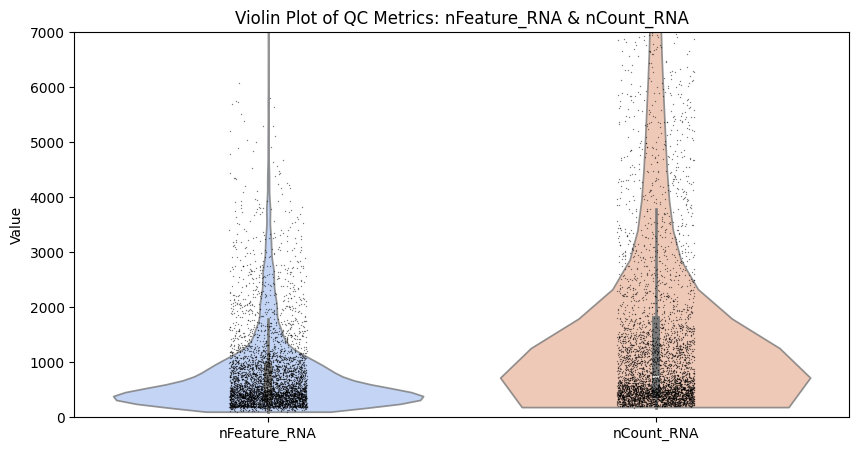

In [ ]:
# grab renamed QC metrics
qc_metrics = az_adata.obs[["nFeature_RNA", "nCount_RNA"]].copy()

# melt into long format for plotting
qc_metrics = qc_metrics.melt(var_name="QC Metric", value_name="Value")


plt.figure(figsize=(10, 5))

sns.violinplot(
    x="QC Metric",
    y="Value",
    data=qc_metrics,
    palette="coolwarm",
    inner="box",
    cut=0,
    alpha=0.8
)
sns.stripplot(
    x="QC Metric",
    y="Value",
    data=qc_metrics,
    color="black",
    size=1,
    alpha=0.5,
    jitter=True
)


plt.yscale("linear")    # or log for skewed distributions
plt.ylim(0, 7000)
plt.xlabel("")
plt.ylabel("Value")
plt.title("Violin Plot of QC Metrics: nFeature_RNA & nCount_RNA")

plt.show()

- `nFeatureRNA` =  number of unique genes (or features) detected in each cell.
- `nCount_RNA` = sum of counts (or RNA transcripts) for all genes per cell. Interpretation is the same as features/cell.

Cells with very low `nFeature_RNA` may indicate poor-quality cells (e.g., empty droplets or dead cells), while cells with very high `nFeature_RNA` might indicate doublets or multiplets.

In [ ]:
min_genes = 100
max_genes = 4000
min_umis = 100


az_adata = az_adata[(az_adata.obs["nFeature_RNA"] >= min_genes) &
              (az_adata.obs["nFeature_RNA"] <= max_genes) &
              (az_adata.obs["nCount_RNA"] >= min_umis)].copy()


print(f"Filtered dataset shape: {az_adata.shape}")

Filtered dataset shape: (4960, 20000)


Now that QC is done, let's proceed with:

- Normalizing and transforming the data
- Identifying highly variable genes
- Scaling the data for PCA/clustering
- Dimensionality reduction (PCA, UMAP)
- Clustering to identify cell types

Since ML models work better with informative features, we’ll start by selecting highly variable genes.

In [ ]:
# need to first normalize and log transform
sc.pp.normalize_total(az_adata, target_sum=1e4)
sc.pp.log1p(az_adata)

In [ ]:
# explicitly set var_names as gene/feature names
az_adata.var_names = az_adata.var["feature_name"]
az_adata.var_names_make_unique()

In [ ]:
sc.pp.highly_variable_genes(az_adata, flavor="seurat", n_top_genes=5000)

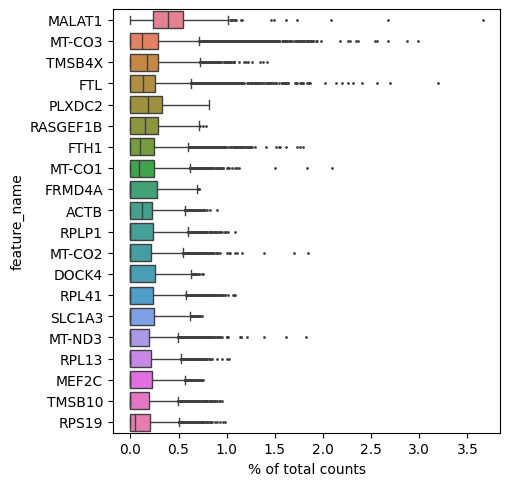

In [ ]:
sc.pl.highest_expr_genes(az_adata, n_top=20)

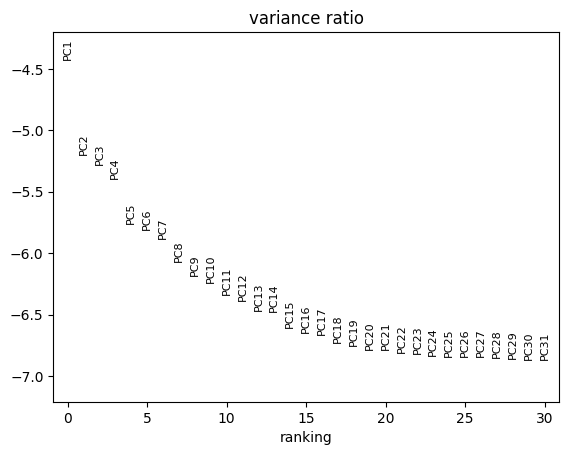

In [ ]:
# scale data
sc.pp.scale(az_adata, max_value=10) # max_value caps extreme z-scores to mitigate outliers

# perform PCA
sc.tl.pca(az_adata, svd_solver='arpack')

# visualize PCs
sc.pl.pca_variance_ratio(az_adata, log=True)

In [ ]:
# save PCs
az_adata.obsm['X_pca'] = az_adata.obsm['X_pca'][:, :30]  # keep the top 30 components

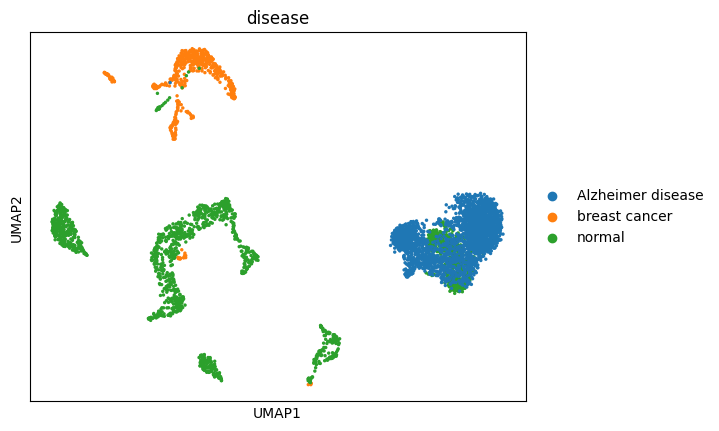

In [ ]:
# compute neighborhood graph
sc.pp.neighbors(az_adata, n_pcs=30)

# cluster + viz cells
sc.tl.umap(az_adata, n_components=2)
sc.pl.umap(az_adata, color='disease')

Now that we've processed our data, let's get on to the machine learning!

We'll need to create labels for our supervised learning model. For this, prior drug-target knowledge is necessary. So in our case, we'll use a publicly accessible dataset from [Open Targets](https://platform.opentargets.org/downloads/data) containing generic druggable targets and their associated metadata, to classify our genes of interest as encoding druggable targets or not.

In [ ]:
target_data = pd.read_csv(
    "/content/drive/MyDrive/genspace/merged-data",
    quotechar='"',
    skipinitialspace=True,
    engine="python",
    on_bad_lines="skip"
)

print(target_data.head())

                id approvedSymbol         biotype  \
0  ENSG00000000971            CFH  protein_coding   
1  ENSG00000007001           UPP2  protein_coding   
2  ENSG00000009694          TENM1  protein_coding   
3  ENSG00000011009         LYPLA2  protein_coding   
4  ENSG00000019582           CD74  protein_coding   

                                       transcriptIds  \
0  ['ENST00000359637' 'ENST00000695984' 'ENST0000...   
1  ['ENST00000605860' 'ENST00000460456' 'ENST0000...   
2  ['ENST00000422452' 'ENST00000371130' 'ENST0000...   
3  ['ENST00000374503' 'ENST00000374501' 'ENST0000...   
4  ['ENST00000518797' 'ENST00000523836' 'ENST0000...   

                                 canonicalTranscript  \
0  {'id': 'ENST00000367429', 'chromosome': '1', '...   
1  {'id': 'ENST00000005756', 'chromosome': '2', '...   
2  {'id': 'ENST00000422452', 'chromosome': 'X', '...   
3  {'id': 'ENST00000374514', 'chromosome': '1', '...   
4  {'id': 'ENST00000009530', 'chromosome': '5', '...   

       

In [ ]:
az_adata.var

,soma_joinid,feature_id,feature_name,feature_type,feature_length,nnz,n_measured_obs,highly_variable,means,dispersions,dispersions_norm,mean,std
feature_name,,,,,,,,,,,,,
LINC01409,0,ENSG00000237491,LINC01409,lncRNA,1059,7958785,92252850,True,4.426161e-01,3.450652,1.560032,0.078768,0.473782
NOC2L,1,ENSG00000188976,NOC2L,protein_coding,1244,18685092,105784525,False,3.360653e-01,3.080726,0.291864,0.087400,0.428276
PERM1,2,ENSG00000187642,PERM1,protein_coding,2765,664016,95688802,False,1.719788e-03,1.818492,-1.535739,0.000601,0.032274
ENSG00000272512.1,3,ENSG00000272512,ENSG00000272512.1,lncRNA,2086,927207,91649589,False,1.217195e-02,2.987673,0.369215,0.002782,0.076396
HES4,4,ENSG00000188290,HES4,protein_coding,961,19206715,105542421,False,9.564029e-02,2.958603,0.321851,0.025165,0.221804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01921,19995,ENSG00000223874,LINC01921,lncRNA,581,104239,78543655,False,1.000000e-12,NaN,NaN,0.000000,1.000000
LINC01078,19996,ENSG00000223880,LINC01078,lncRNA,387,1004,78366792,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000223881.2,19997,ENSG00000223881,ENSG00000223881.2,lncRNA,754,41590,76496879,False,1.000000e-12,NaN,NaN,0.000000,1.000000


In [ ]:
# grab gene names from target data
target_genes = target_data['approvedSymbol'].unique()

# add 'is_target' col to az_adata.var; 1 if in target data otherwise 0
az_adata.var['is_target'] = az_adata.var.index.isin(target_genes).astype(int)
print(az_adata.var.head())

                   soma_joinid       feature_id       feature_name  \
feature_name                                                         
LINC01409                    0  ENSG00000237491          LINC01409   
NOC2L                        1  ENSG00000188976              NOC2L   
PERM1                        2  ENSG00000187642              PERM1   
ENSG00000272512.1            3  ENSG00000272512  ENSG00000272512.1   
HES4                         4  ENSG00000188290               HES4   

                     feature_type  feature_length       nnz  n_measured_obs  \
feature_name                                                                  
LINC01409                  lncRNA            1059   7958785        92252850   
NOC2L              protein_coding            1244  18685092       105784525   
PERM1              protein_coding            2765    664016        95688802   
ENSG00000272512.1          lncRNA            2086    927207        91649589   
HES4               protein_coding  

In [ ]:
#na_columns = az_adata.var.isna().any()
#print(na_columns)

soma_joinid         False
feature_id          False
feature_name        False
feature_type        False
feature_length      False
nnz                 False
n_measured_obs      False
highly_variable     False
means               False
dispersions          True
dispersions_norm     True
mean                False
std                 False
is_target           False
dtype: bool


In [ ]:
print(az_adata.var.columns)

Index(['soma_joinid', 'feature_id', 'feature_name', 'feature_type',
       'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm', 'mean', 'std', 'is_target'],
      dtype='object')


Now that we've used the drug-target information to label druggable targets in our data appropriately, let's prepare our features and labels for machine learning.

Note: The dimensions of `az_adata.X` need to align with those of `az_adata.var['is_target'].`

- az_adata.X is a matrix with dimensions (n_cells, n_genes), where n_cells is the number of cells and n_genes is the number of genes/features.
- az_adata.var['is_target'] is a vector with length n_genes, representing annotations for genes.

In [ ]:
# features: genes
X = az_adata.X.T

# labels: gene targets
y = az_adata.var['is_target'].values


In [ ]:
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")


Features (X): (20000, 4960)
Labels (y): (20000,)


In [ ]:
import numpy as np
print("Target / Non-target counts:", np.bincount(y))

Target / Non-target counts: [16401  3599]


Now to build a Random Forest classifier. This is an ensemble algorithm that combines multiple Decision Trees to make predictions. Essentially, this creates a "forest" of trees, where each tree is trained on a random subset of data and features. This results in a more robust and accurate prediction, by taking the collective decision from all the trees.

W'll now split our data into 3:
1. For training the model
2. For validating the performance (inference)
3. For testing (predicting) "never-seen" genes

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
)


# split off test set 60%
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split leftover set into train + val 20/20
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (12000, 4960), Val: (4000, 4960), Test: (4000, 4960)


### Train model

This should take ~7 mins.

In [ ]:
# talk more about how we get datasets of single cell repositories like the cellxgene census


# initialize rf
rf_clf = RandomForestClassifier(n_estimators=100,
                                random_state=42,
                                class_weight="balanced")  # pay more attention to the minority class

# train
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

### Evaluate performance

- Accuracy: Basic evaluation metric that measures how many predictions the model got correct out of all predictions made

- Precision (Positive Predictive Value):
The percentage of predicted positives that are actually correct

- Recall (Sensitivity or True Positive Rate):
The percentage of actual positives that were correctly predicted


Question 1: Why is accuracy not a great metric to use for imbalanced classes?

Question 2: In what case might someone prioritize recall performance over precision?

### Plot ROC-AUC curve

The ROC curve is a plot of:

- True Positive Rate (Recall or Sensitivity) on the Y-axis i.e how many actual positives were correctly identified
- False Positive Rate (1 - Specificity) on the X-axis i.e how many actual negatives were incorrectly classified as positives

The AUC (Area Under the Curve) quantifies the overall performance of the model.

- AUC = 1.0: Perfect model; ideal separation of classes
- AUC = 0.5: Random guessing; no discrimination power
- AUC < 0.5: Worse than random; model is making incorrect predictions



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


# evaluate training

# generate predictions on training set
y_train_pred = rf_clf.predict(X_train)          # predicted class labels
y_train_prob = rf_clf.predict_proba(X_train)[:, 1]  # what % of trees voted for this class (not stats probability)

print("Training Set Metrics:")
print(classification_report(y_train, y_train_pred))
print("ROC AUC:", roc_auc_score(y_train, y_train_prob))

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9841
           1       1.00      0.91      0.95      2159

    accuracy                           0.98     12000
   macro avg       0.99      0.96      0.97     12000
weighted avg       0.98      0.98      0.98     12000

ROC AUC: 0.9953843226335323


In [ ]:
# validate
y_val_pred = rf_clf.predict(X_val)
y_val_prob = rf_clf.predict_proba(X_val)[:, 1]

print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3280
           1       0.18      0.02      0.03       720

    accuracy                           0.81      4000
   macro avg       0.50      0.50      0.46      4000
weighted avg       0.70      0.81      0.74      4000

ROC AUC: 0.512108316395664


So our model performed well in training, but is randomly guessing on our validation dataset. Why is it overfitting? Let's try to reduce the feature space.

In [ ]:
az_adata_hvg = az_adata[:, az_adata.var['highly_variable']].copy()

In [ ]:
X = az_adata_hvg.X.T

# labels: gene targets
y = az_adata_hvg.var['is_target'].values

In [ ]:
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")

Features (X): (5000, 4960)
Labels (y): (5000,)


In [ ]:
print("Target / Non-target counts:", np.bincount(y))

Target / Non-target counts: [4098  902]


In [ ]:
# split off test set 60%
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split leftover set into train + val 20/20
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (3000, 4960), Val: (1000, 4960), Test: (1000, 4960)


In [ ]:
# initialize rf
rf_clf = RandomForestClassifier(n_estimators=100,
                                random_state=42,
                                class_weight="balanced")  # pay more attention to the minority class

# train
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# generate predictions on training set
y_train_pred = rf_clf.predict(X_train)          # predicted class labels
y_train_prob = rf_clf.predict_proba(X_train)[:, 1]  # probability for positive class

print("Training Set Metrics:")
print(classification_report(y_train, y_train_pred))
print("ROC AUC:", roc_auc_score(y_train, y_train_prob))

Training Set Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2458
           1       1.00      1.00      1.00       542

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

ROC AUC: 1.0


In [ ]:
# validate
y_val_pred = rf_clf.predict(X_val)
y_val_prob = rf_clf.predict_proba(X_val)[:, 1]

print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_prob))

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       820
           1       0.15      0.03      0.05       180

    accuracy                           0.80      1000
   macro avg       0.49      0.50      0.47      1000
weighted avg       0.70      0.80      0.74      1000

ROC AUC: 0.501588753387534


In [ ]:
# infer aka predict or "classify" new targets
y_test_pred = rf_clf.predict(X_test)
y_test_prob = rf_clf.predict_proba(X_test)[:, 1]

print("\nTest Set Metrics:")
print(classification_report(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_prob))


Test Set Metrics:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       820
           1       0.30      0.04      0.08       180

    accuracy                           0.81      1000
   macro avg       0.56      0.51      0.49      1000
weighted avg       0.73      0.81      0.75      1000

ROC AUC: 0.5034925474254742


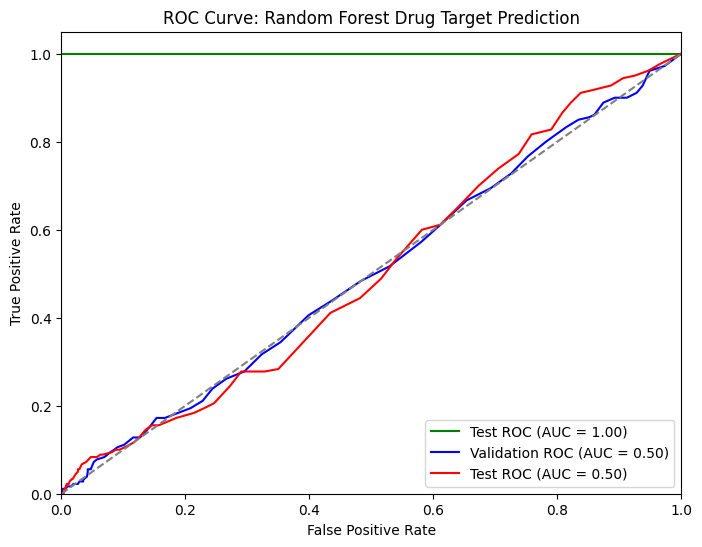

In [ ]:
# compute ROC curve for the training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# compute ROC-AUC curve for validation
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute ROC-AUC curve for test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='green', label=f'Test ROC (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='blue', label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Drug Target Prediction')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# compare predictions to true labels
test_results = pd.DataFrame({
    "gene": az_adata.var_names[X_test.index] if hasattr(X_test, "index") else np.arange(len(y_test)),
    "true_label": y_test,
    "predicted_label": y_test_pred,
    "predicted_probability": y_test_prob
})

print(test_results.head())

   gene  true_label  predicted_label  predicted_probability
0     0           0                0                   0.26
1     1           0                0                   0.22
2     2           0                0                   0.04
3     3           0                1                   0.60
4     4           0                0                   0.32


In [ ]:
test_results

,gene,true_label,predicted_label,predicted_probability
0,0,0,0,0.26
1,1,0,0,0.22
2,2,0,0,0.04
3,3,0,1,0.60
4,4,0,0,0.32
...,...,...,...,...
995,995,0,0,0.27
996,996,0,0,0.16
997,997,0,0,0.05
998,998,0,0,0.24


In [ ]:
test_results.shape

(1000, 4)

In [ ]:
# grab indices of predicted targets
predicted_targets_indices = np.where(y_test_pred == 1)[0]

# map to gene names from az_adata.var
predicted_targets = az_adata.var.iloc[predicted_targets_indices].feature_name.values

print(f"Predicted Drug Targets ({len(predicted_targets)} genes):")
print(predicted_targets)

Predicted Drug Targets (27 genes):
['ENSG00000272512.1' 'TNFRSF4' 'DDI2' 'SRARP' 'FAM110D' 'RBBP4' 'ZMYM6'
 'CDCA8' 'CAP1' 'CCDC30' 'CCDC24' 'RNF220' 'EIF2B3' 'MAST2' 'UQCRH'
 'ATPAF1' 'FAF1' 'GBP4' 'GLMN' 'PALMD' 'SLC30A7' 'GSTM4' 'SRGAP2B' 'MRPL9'
 'TPM3' 'ATF6' 'SLC19A2']


Our model performance isn't great, so let's try improving its predictive capability by collapsing the individual gene expression values across cells to a mean value (reduces multidimensionality).

In [ ]:
# compute mean expression per gene
X_mean = X.mean(axis=1, keepdims=True)  # shape: n_genes x 1

y = az_adata_hvg.var['is_target'].values

In [ ]:
# split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X_mean, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# predict
y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)[:, 1]

y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:, 1]

In [ ]:
print("Validation Set Report:")
print(classification_report(y_val, y_val_pred))

print("Test Set Report:")
print(classification_report(y_test, y_test_pred))


val_roc = roc_auc_score(y_val, y_val_prob)
test_roc = roc_auc_score(y_test, y_test_prob)

print(f"Validation ROC AUC: {val_roc:.3f}")
print(f"Test ROC AUC: {test_roc:.3f}")

Validation Set Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       820
           1       0.13      0.13      0.13       180

    accuracy                           0.68      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.68      0.68      0.68      1000

Test Set Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       820
           1       0.19      0.19      0.19       180

    accuracy                           0.71      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.71      0.71      0.71      1000

Validation ROC AUC: 0.457
Test ROC AUC: 0.535


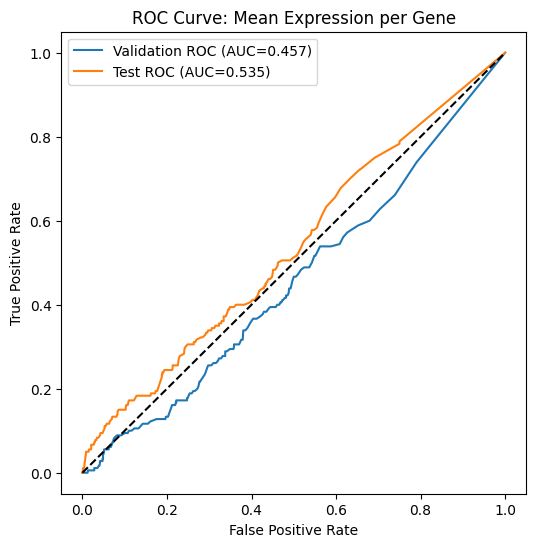

In [ ]:
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC={val_roc:.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={test_roc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Mean Expression per Gene')
plt.legend()
plt.show()

In [ ]:
predicted_indices = np.where(y_test_pred == 1)[0]
predicted_genes = az_adata.var.index[predicted_indices]
print("Predicted drug targets:", predicted_genes.tolist())

Predicted drug targets: ['HES4', 'UBE2J2', 'DVL1', 'MXRA8', 'VWA1', 'SLC35E2A', 'GABRD', 'FAAP20', 'HES5', 'ENSG00000272235.1', 'DFFB', 'KCNAB2', 'THAP3', 'DNAJC11', 'CAMTA1', 'ERRFI1', 'ENO1', 'MIR34AHG', 'SLC25A33', 'CENPS', 'SRM', 'FBXO2', 'MAD2L2', 'KIAA2013', 'PLOD1', 'DHRS3', 'PRDM2', 'TMEM51', 'DNAJC16', 'EPHA2', 'PADI2', 'NBL1', 'PLA2G5', 'DDOST', 'ALPL', 'USP48', 'HNRNPR', 'ZNF436', 'ASAP3', 'ID3', 'PNRC2', 'SRSF10', 'STPG1', 'CLIC4', 'TMEM50A', 'MAN1C1', 'ZNF593', 'CEP85', 'ZDHHC18', 'SLC9A1', 'CD164L2', 'PPP1R8', 'XKR8', 'ENSG00000270605.1', 'MED18', 'PTPRU', 'PUM1', 'NKAIN1', 'FABP3', 'SERINC2', 'BSDC1', 'ZBTB8A', 'ZBTB8OS', 'SYNC', 'AK2', 'ENSG00000284773.1', 'PSMB2', 'CLSPN', 'MAP7D1', 'LSM10', 'CSF3R', 'DNALI1', 'FHL3', 'ZMPSTE24-DT', 'ZMPSTE24', 'SMAP2', 'CCDC30', 'CFAP144', 'MED8', 'ST3GAL3', 'IPO13', 'DPH2', 'KIF2C', 'PLK3', 'TOE1', 'AKR1A1', 'MAST2', 'TSPAN1', 'MKNK1', 'EFCAB14', 'ELAVL4', 'RNF11', 'ECHDC2', 'CZIB', 'NDC1', 'LRRC42', 'NFIA-AS2', 'CACHD1', 'SERBP1', '